# Deep Convolutional Generative Adversarial Network (DCGAN)

In [1]:
import os
import sys
import datetime as dt

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('datasets/MNIST/', one_hot=True)

Extracting datasets/MNIST/train-images-idx3-ubyte.gz
Extracting datasets/MNIST/train-labels-idx1-ubyte.gz
Extracting datasets/MNIST/t10k-images-idx3-ubyte.gz
Extracting datasets/MNIST/t10k-labels-idx1-ubyte.gz


## Hyperparameters

In [9]:
# Inputs
image_size = 28
image_channel = 1
image_size_flat = image_size * image_size * image_channel

# Network
filter_size = 5
conv1_size = 16
conv2_size = 32
conv3_size = 128
fc1_size = 512
fc2_size = 256
fc3_size = 1

# Training
learning_rate = 1e-2
batch_size = 24
iterations = 10000
save_interval = 100
log_interval = 500

## Helper functions

In [6]:
def plot_images(imgs, size=28, name=None):
    grid = int(np.sqrt(len(imgs)))
    fig, axes = plt.subplots(grid, grid)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    if name:
        plt.suptitle(name)
    for i, ax in enumerate(axes.flat):
        ax.imshow(imgs[i].reshape([size, size]), cmap='binary', interpolation='bicubic')
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

def weight(shape, name):
    initial = tf.truncated_normal(shape=shape, mean=0, stddev=0.4)
    return tf.Variable(initial, name=name)

def bias(shape, name):
    initial = tf.zeros(shape=[shape])
    return tf.Variable(initial, name=name)

def conv_block(layer, W, b):
    layer = tf.nn.conv2d(layer, W, strides=[1, 1, 1, 1], padding='SAME')
    layer = layer + b  # add bias
    layer = tf.nn.relu(layer)
    layer = tf.nn.max_pool(layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    return layer
# Convolutional block
def conv_block(layer, W, b):
    layer = tf.nn.conv2d(layer, W, strides=[1, 1, 1, 1], padding='SAME')
    layer = layer + b  # add bias
    layer = tf.nn.relu(layer)
    layer = tf.nn.max_pool(layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    return layer

# Deconvolutional block
def deconv_block(layer, W, b, activation_fn=tf.nn.relu, batch_norm=None):
    layer = tf.nn.conv2d(layer, W, strides=[1, 2, 2, 1], padding='SAME')
    layer = layer + b
    if batch_norm:
        layer = tf.contrib.layers.batch_norm(layer, epsilon=1e-5, scope=batch_norm)
    layer = activation_fn(layer)
    return layer

# Fully connected layer
def fully_connected(layer, W, b, use_relu=True):
    layer = tf.matmul(layer, W) + b
    if use_relu:
        layer = tf.nn.relu(layer)
    return layer

# Flatten layer
def flatten(layer):
    shape = layer.get_shape()
    features = np.array(shape[1:4], dtype=np.int32).prod()
    flattened = tf.reshape(layer, [-1, features])
    return flattened, features

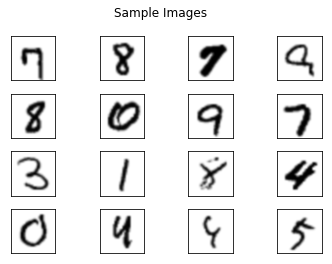

In [7]:
sample_images = data.test.next_batch(16)[0]
plot_images(sample_images, name='Sample Images')

In [10]:
def discriminator(image, reuse=None):
    with tf.get_variable(tf.get_variable_scope(), reuse=reuse):
        # 1st convolutional layer
        W_conv1 = weight(shape=[filter_size, filter_size, image_size_flat, conv1_size], name='d_W_conv1')
        b_conv1 = bias(shape=conv1_size, name='d_b_conv1')
        conv1 = conv_block(image, W_conv1, b_conv1)
        # 2nd convolutional layer
        W_conv2 = weight(shape=[filter_size, filter_size, conv1_size, conv2_size], name='d_W_conv2')
        b_conv2 = bias(shape=conv2_size, name='d_b_conv2')
        conv2 = conv_block(conv1, W_conv2, b_conv2)
        # 2nd convolutional layer
        W_conv3 = weight(shape=[filter_size, filter_size, conv2_size, conv3_size], name='d_W_conv3')
        b_conv3 = bias(shape=conv3_size, name='d_b_conv3')
        conv3 = conv_block(conv2, W_conv3, b_conv3)
        # Flatten
        flattened, flat_size = flatten(layer=conv3)
        # 1st Fully connected layer
        W_fc1 = weight(shape=[flat_size, fc1_size], name='d_W_fc1')
        b_fc1 = bias(shape=fc1_size, name='d_b_fc1')
        fc1 = fully_connected(flattened, W_fc1, b_fc1)
        # 2nd Fully connected layer
        W_fc2 = weight(shape=[fc1_size, fc2_size], name='d_W_fc2')
        b_fc2 = bias(shape=fc2_size, name='d_b_fc2')
        fc2 = fully_connected(flattened, W_fc2, b_fc2)
        # Classification layer
        W_classify = weight(shape=[fc2_size, fc3_size], name='d_W_classify')
        b_classify = bias(shape=fc3_size, name='d_b_classify')
        classify = fully_connected(fc2, W_classify, b_classify, use_relu=False)
        return classify

In [ ]:
def generator(noise, batch_size, noise_dim)